# Events extraction

На данном шаге мы выделим ограниченный набор событий для каждого запроса. 

__Для чего это нужно.__

Запрос вида /f13erj23231.jpg ничего нам не скажет о характере самого запроса, а сам по себе такой запрос крайне уникален. Нам достаточно знать, что это загрузка изображения и мы можем заменить набор символов специальным токеном. Тогда запрос примет вид /image. И несколько запросов такого вида подряд будут говорить уже о загрузке статики при переходе на страницу, например.

Количество таких токенов задается экспертно при исследовании данных. Для замены request_uri на event каждый запрос разбивается на подстроки по символу / и каждая подстрока матчится с набором регулярных выражений, соответствующих нашим специальным токенам.

In [1]:
import pandas as pd
from tqdm.notebook import tqdm

import re
import matplotlib.pyplot as plt

In [2]:
dtype = {
    'time': 'str',
    'session_id': 'uint',
    'request_uri': 'str',
}

In [3]:
data = pd.read_csv('data_with_sess_id.csv', dtype=dtype)
data.head()

,time,session_id,request_uri
0,2022-02-07 18:43:07.694,3059192787115454724,/
1,2022-02-07 18:43:12.379,3059192787115454724,/
2,2022-02-07 18:43:14.382,3059192787115454724,/view/theme/example2019/js/libs/widjet.js
3,2022-02-07 18:43:17.314,3059192787115454724,/xhr/cart/
4,2022-02-07 18:43:17.330,3059192787115454724,/xhr/productsliders/?slider_id=18


In [4]:
data.request_uri.nunique()

298125

In [5]:
data.request_uri.value_counts()[:10]

/xhr/cart/                 386375
/getproductsize/342434/    206872
/getproductsize/344422/    163046
/getproductsize/338875/    157709
/getproductsize/342531/    157462
/getproductsize/314556/    141074
/sp-push-worker-fb.js      100269
/xhr/recommblock/           89922
/xhr/lastviewed/            86583
/getproductsize/335987/     74841
Name: request_uri, dtype: int64

In [6]:
uri_depth = data.request_uri.apply(lambda x: len(x.split('/'))).to_list()

Так же полезно узнать глубину запросов в данных, до которой можно обрезать запрос, т.к. дальнейшая часть запроса не будет нести никакой полезной информации. Ограничим глубину запроса до 5.

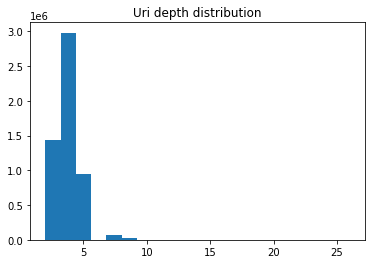

In [7]:
plt.hist(uri_depth, bins=20)
plt.title('Uri depth distribution')
plt.show()

In [8]:
patterns = {
    "hypertext": re.compile("\.(s?html?|S?HTML?)$"),
    "style": re.compile("\.(less|css)$"),
    "script": re.compile("\.(js)$"),
    "map": re.compile("\.(js|css)\\.map$"),
    "config": re.compile("\.(xml|json|yml)$"),
    "file": re.compile("\.(md|pdf|PDF|zip|rtf|docx?|woff2?|txt|csv|(t|o)tf|eot|xlsx|do|pptx?)$"),
    "video_audio": re.compile("\.(avi|mp(4|3)|vob|mov|mkv|f(l|4)v|wm(v|a)|3g(p|2)|webm|wav|dvd|ogv|(f|a)lac|aac|ogg|ts)$"),
    "image": re.compile("\.(avif|gif|GIF|jpe?g|JPG|jfif|pjpeg|pjp|a?png|PNG|svg|webp|ico|cgi|bmp)$"),
    "digits": re.compile("^\d+$"),
    "hash": re.compile("^(0?[xX])?([0-9a-fA-F]|\-)+$"),
    "unicode": re.compile("(%\w+)+%?"),
    "content": re.compile("^(-|_)?([a-zA-Z\d]*)((-|_|\d)+[a-zA-Z\d]*)*(-|_|\d)+[a-zA-Z\d]*$"),
    "version": re.compile("\.?(\d+\.)*\d+$")
}

In [20]:
def get_event(uri, depth=5):
    uri = uri.split('?')[0]
    result = []
    for element in uri.split('/')[:depth]:
        for pattern_name, pattern in patterns.items():
            match = pattern.search(element)
            if match:
                result.append(pattern_name)
                break
        if not match:
            result.append(element)
    return '/'.join(result)

In [18]:
s = data[data.request_uri.apply(lambda x: len(x.split('/')) > 10)].request_uri.values[1]
s

'/media/catalog/product/cache/1/image/607x607/9df78eab33525d08d6e5fb8d27136e95/s/h/shoes-red-wing-9042-beckman-oxford-brown-7.jpg'

Для примера не будем ограничивать глубину запроса

In [22]:
get_event(s, 20)

'/media/catalog/product/cache/digits/image/content/hash/s/h/image'

In [12]:
%%time
uniq_requests = data[['request_uri']].drop_duplicates()
uniq_requests['event'] = uniq_requests.request_uri.apply(get_event)

CPU times: user 2.47 s, sys: 9.94 ms, total: 2.48 s
Wall time: 2.48 s


In [13]:
data = data.merge(uniq_requests, on='request_uri', how='left')

300 тысяч уникальных запросов превратились в 1500 уникальных событий

In [14]:
data.event.nunique()

1574

In [15]:
data.event.value_counts()[:10]

/getproductsize/digits/    2130291
/goods/digits/content/      611701
/xhr/cart/                  386375
/yeezy/                     211886
/nike/                      205255
/image                      196788
/new/                       178203
/goods/digits/hash/         138875
/obuv/                      131468
/getproductinfo/digits      116704
Name: event, dtype: int64

In [16]:
data.event.value_counts(ascending=True)[:10]

/muzhskoe/content/ellesse/             1
/muzhskoe/aksessuary/hestra/           1
/content/bagazh/ryukzaki/fjallraven    1
/zhenskoe/odezhda/bryuki/content       1
/goods/digits/content/https:           1
/zhenskoe/aksessuary/shapki/content    1
/muzhskoe/odezhda/polo/evisu           1
/zhenskoe/aksessuary/panamy/stussy     1
/goods/digits/hash/'                   1
/muzhskoe/content/kurtki/nedorogie     1
Name: event, dtype: int64

In [17]:
data.loc[:, ['time', 'session_id', 'event']].to_csv('data_with_events.csv', index=False)